# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn import preprocessing
import warnings
from enum import Enum
import random
%matplotlib inline

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']

# Create copies of original images so that original images remain intact 
X_train_working_copy = X_train.copy()
y_train_working_copy = y_train.copy()
X_valid_working_copy = X_valid.copy()
y_valid_working_copy = y_valid.copy()

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
n_train = X_train_working_copy.shape[0]
n_validation = X_valid_working_copy.shape[0]
image_shape =  str(X_train_working_copy.shape[1]) + ' x ' + str(X_train_working_copy.shape[2]) + ' x ' + str(X_train_working_copy.shape[3])
n_classes = len(np.unique(y_train_working_copy))

print("Number of training images =", n_train)
print("Number of validation images =", n_validation)
print("Image data shape (Height x Width x Color Channels) =", image_shape)
print("Number of classes =", n_classes)

Number of training images = 34799
Number of validation images = 4410
Image data shape (Height x Width x Color Channels) = 32 x 32 x 3
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

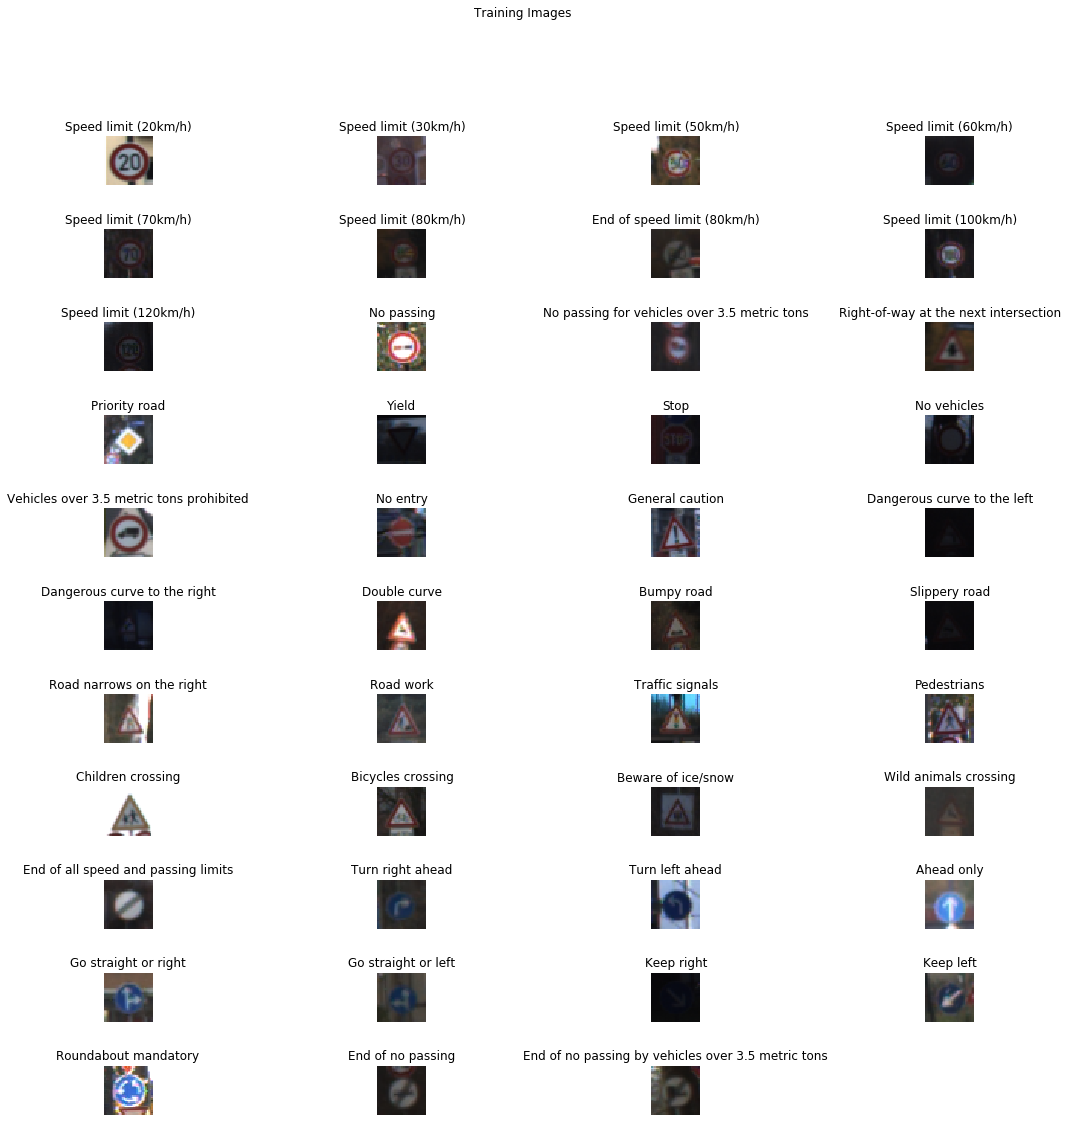

In [3]:
### Data exploration visualization 

df_signnames = pd.read_csv('signnames.csv')

# Draw one image from each class
fig = plt.figure(figsize=(18, 18))
fig.subplots_adjust(hspace = .9, wspace = 0.5)
plt.suptitle('Training Images')
for i in range(0,n_classes):
    plt.subplot(11, 4, i+1)
    # get first (example) image index that has the same (class) value as the for loop's current index
    example_image_index = np.where(y_train_working_copy == i)[0][0]
    # get the row from the signnames csv that has the same ClassId as the example image's value from y_train
    df_example_image = df_signnames[df_signnames['ClassId'] == y_train_working_copy[example_image_index]]
    # get the SignName column value
    label = df_example_image.iloc[0]['SignName']
    plt.imshow(X_train_working_copy[example_image_index])
    plt.title(label)
    plt.axis('off')
plt.show()

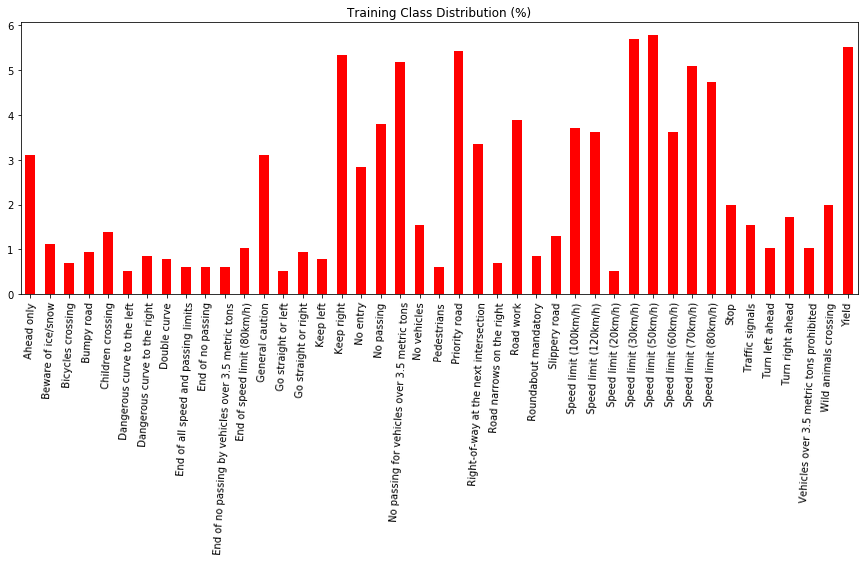

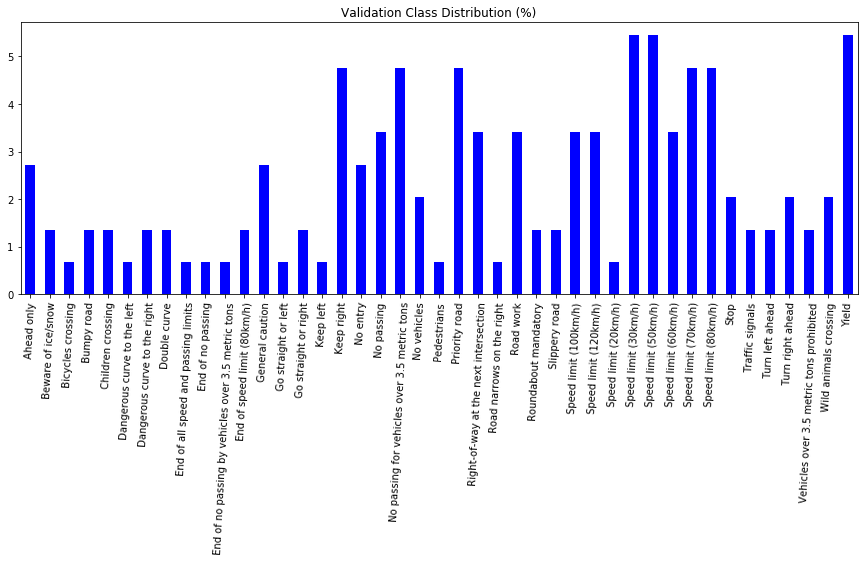

In [4]:
def draw_distribution(classes_data_arr,classes_names_df, join_column='ClassId', group_by_column = 'SignName', title = 'Class Distribution', color = 'r'):
    '''
    Helper function for drawing bar chart of class distribution
    '''
    df_classes = pd.DataFrame(classes_data_arr, columns = list([join_column]))
    df_merged = pd.merge(classes_names_df, df_classes, on=join_column)
    df_bar = pd.DataFrame({'Percentage':(df_merged.groupby([group_by_column]).size()/len(classes_data_arr))*100}).reset_index()
    ax = df_bar.plot(kind='bar', title=title + ' (%)', figsize=(15, 5), legend=False, fontsize=10, color=color)
    ax.set_xticklabels(df_bar.iloc[:][group_by_column], rotation=87)
    plt.show()
    return df_bar

# Draw training data set class distribution
df_bar_train = draw_distribution(y_train_working_copy, df_signnames, 'ClassId', 'SignName', 'Training Class Distribution', 'r')

# Draw validation data set class distribution
df_bar_valid = draw_distribution(y_valid_working_copy, df_signnames, 'ClassId', 'SignName', 'Validation Class Distribution', 'b')

# Draw training/validation data set class distribution comparison
#df_merged = pd.merge(df_bar_train, df_bar_valid, on='SignName',suffixes = ['_Training','_Validation'])
#ax = df_merged.plot(kind='bar', title ="Training/Validation Class Ditribution Comparison", figsize=(25, 10), legend=True, fontsize=14, color = ['r','b'])
#ax.set_xticklabels(df_merged.iloc[:]['SignName'], rotation=87)
#plt.show()



In [5]:
# meta-data for image augmentation operations
can_rotate_15_exclude = [32,38,39]
can_rotate_90_include = [12,15]
can_rotate_180_include = [12,15,17,32,40]
can_transpose_right_include = [39]
can_transpose_left_include = [38]
transpose_pair_dict = {39:38, 38:39}

class Include_Exlude_Flag(Enum):
    INCLUDE = 1
    EXCLUDE = 2
    
class Zoomin_Zoomout_Flag(Enum):
    ZOOM_IN = 1
    ZOOM_OUT = 2
    
def print_classes_percentage(classes_data, classes_to_exclude = [], max_percentage = 100):
    '''
    Helper function for printing out classes' percentage
    '''
    df_percent_print = pd.DataFrame(classes_data,columns = list(['ClassId']))
    grouped = df_percent_print.groupby(['ClassId'])
    grouped_dict = {k: ((len(np.array(v))/len(classes_data))*100) for k, v in grouped.groups.items()}
    for k, v in grouped_dict.items():
        if (k not in classes_to_exclude and v <= max_percentage): print('Percentage for class:{} --> {:0.2f}'.format(k,v))

def get_below_percent_classes(classes_data, percentage = 1, classes_to_exclude = []):
    df_percent_check = pd.DataFrame(classes_data,columns = list(['ClassId']))
    df_percent_check = pd.DataFrame(df_percent_check.groupby(['ClassId']).size(), columns = list(['Count']))
    df_percent_check['Percentage'] = (df_percent_check['Count']/df_percent_check['Count'].sum())*100
    below_percent_classes = df_percent_check.query('Percentage < ' + str(percentage) + ' and ClassId not in ' + str(classes_to_exclude)).index.values
    return below_percent_classes
    
def rotate_images(images, classes, classes_to_check, include_exlude = Include_Exlude_Flag.INCLUDE, angle_range_lower = -15, angle_range_upper = 15):
    '''
    Rotates images by randomly choosing an angle between the provided range (-angle_range to +angle_range)
    Returns new rotated images with class labels and angles
    '''
    if (classes_to_check is None): raise Exception("Param classes can't be null")
    # All images are of the same dims, so calculate rotation matrix once
    image_rows = images[0].shape[0]
    image_cols = images[0].shape[1]
    angle = random.randrange(angle_range_lower,angle_range_upper,3)
    rotation_matrix = cv2.getRotationMatrix2D((image_cols/2,image_rows/2),angle,1)
    result_images = []
    result_classes = []
    result_angles = []
    for image_with_class in zip(images,classes):
        if ((image_with_class[1] in classes_to_check) if (include_exlude == Include_Exlude_Flag.INCLUDE) else (image_with_class[1] not in classes_to_check)):
            result_images.append(cv2.warpAffine(image_with_class[0],rotation_matrix,(image_cols,image_rows))) 
            result_classes.append(image_with_class[1])
            result_angles.append(angle)
            
    return np.array(result_images),np.array(result_classes),np.array(result_angles)

def transpose_images(images, classes, classes_to_flip, flipped_class_lookup, include_exlude = Include_Exlude_Flag.INCLUDE, direction = 'right'):
    '''
    Horizontally flips images 
    Returns new rotated images with flipped class labels
    '''
    if (classes_to_flip is None): raise Exception("Param classes can't be null")
    # All images are of the same dims, so calculate rotation matrix once
    image_rows = images[0].shape[0]
    image_cols = images[0].shape[1]
    rotation_matrix = cv2.getRotationMatrix2D((image_cols/2,image_rows/2),90 if direction == 'right' else -90,1)
    result_images = []
    result_classes = []
    for image_with_class in zip(images,classes):
        if ((image_with_class[1] in classes_to_flip) if (include_exlude == Include_Exlude_Flag.INCLUDE) else (image_with_class[1] not in classes_to_flip)):
            result_images.append(cv2.warpAffine(image_with_class[0],rotation_matrix,(image_cols,image_rows))) 
            result_classes.append(flipped_class_lookup[image_with_class[1]])
            
    return np.array(result_images),np.array(result_classes)

def zoom_images(images, classes, classes_to_check, include_exlude = Include_Exlude_Flag.INCLUDE, zoomin_zoomout = Zoomin_Zoomout_Flag.ZOOM_IN, zoom_pixels = 2):
    '''
    Zooms images in or out 
    '''
    result_images = []
    result_classes = []
    image_height = images[0].shape[0]
    image_width = images[0].shape[1]
    
    pts_1 = np.float32([[zoom_pixels,zoom_pixels],[image_height-zoom_pixels,zoom_pixels],[zoom_pixels,image_width-zoom_pixels],[image_height-zoom_pixels,image_width-zoom_pixels]])
    pts_2 = np.float32([[0,0],[image_height,0],[0,image_width],[image_height,image_width]])
    
    pts_from = pts_1 if zoomin_zoomout == Zoomin_Zoomout_Flag.ZOOM_IN else pts_2
    pts_to = pts_2 if zoomin_zoomout == Zoomin_Zoomout_Flag.ZOOM_IN else pts_1
    pers_trans = cv2.getPerspectiveTransform(pts_from,pts_to)
    
    for image_with_class in zip(images,classes):
        if ((image_with_class[1] in classes_to_check) if (include_exlude == Include_Exlude_Flag.INCLUDE) else (image_with_class[1] not in classes_to_check)):
            result_images.append(cv2.warpPerspective(image_with_class[0],pers_trans,(image_height,image_width)))
            result_classes.append(image_with_class[1])
    return np.array(result_images),np.array(result_classes)

def shear_images(images, classes, classes_to_check, include_exlude = Include_Exlude_Flag.INCLUDE):
    '''
    Applies homography (affine transformation) 
    Basically it changes the viewing angle i.e. as if one is looking at the image from a different angle
    '''
    result_images = []
    result_classes = []
    image_height = images[0].shape[0]
    image_width = images[0].shape[1]
    
    pts_from = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts_to = np.float32([[-10,-10],[44,8],[10,40],[44,40]])

    homography_matrix,status = cv2.findHomography(pts_to,pts_from)
        
    for image_with_class in zip(images,classes):
        if ((image_with_class[1] in classes_to_check) if (include_exlude == Include_Exlude_Flag.INCLUDE) else (image_with_class[1] not in classes_to_check)):
            result_images.append(cv2.warpPerspective(image_with_class[0],homography_matrix,(image_height,image_width)))
            result_classes.append(image_with_class[1])
    return np.array(result_images),np.array(result_classes)

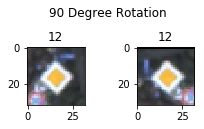

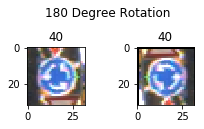

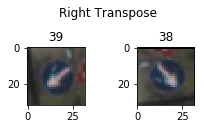

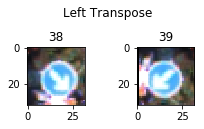

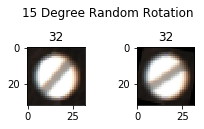

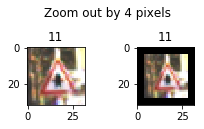

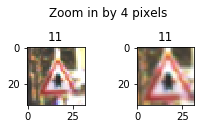

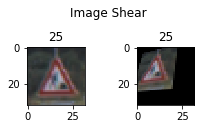

In [6]:
# Image augmentation examples

## 90 degree rotation
example_image = X_train[y_train == 12][0].copy()
example_image = example_image.reshape(1,32,32,3)
rotated_images,_, _ = rotate_images(example_image,np.array([12]),can_rotate_90_include,Include_Exlude_Flag.INCLUDE,90,91)
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(hspace = .1, wspace = .9)
plt.suptitle('90 Degree Rotation')
plt.subplot(1, 2, 1)
plt.imshow(example_image[0])
plt.title(str(12))
plt.subplot(1, 2, 2)
plt.imshow(rotated_images[0])
plt.title(str(12))
plt.show()
##

## 180 degree rotation
example_image = X_train[y_train == 40][0].copy()
example_image = example_image.reshape(1,32,32,3)
rotated_images,_, _ = rotate_images(example_image,np.array([40]),can_rotate_180_include,Include_Exlude_Flag.INCLUDE,180,181)
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(hspace = .1, wspace = .9)
plt.suptitle('180 Degree Rotation')
plt.subplot(1, 2, 1)
plt.imshow(example_image[0])
plt.title(str(40))
plt.subplot(1, 2, 2)
plt.imshow(rotated_images[0])
plt.title(str(40))
plt.show()
##

## Right transpose
example_image = X_train[y_train == 39][0].copy()
example_image = example_image.reshape(1,32,32,3)
transposed_images,_ = transpose_images(example_image,np.array([39]),can_transpose_right_include,transpose_pair_dict,Include_Exlude_Flag.INCLUDE,'right')
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(hspace = .1, wspace = .9)
plt.suptitle('Right Transpose')
plt.subplot(1, 2, 1)
plt.imshow(example_image[0])
plt.title(str(39))
plt.subplot(1, 2, 2)
plt.imshow(transposed_images[0])
plt.title(str(38))
plt.show()
##

## Left transpose
example_image = X_train[y_train == 38][123].copy()
example_image = example_image.reshape(1,32,32,3)
transposed_images,_ = transpose_images(example_image,np.array([38]),can_transpose_left_include,transpose_pair_dict,Include_Exlude_Flag.INCLUDE,'left')
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(hspace = .1, wspace = .9)
plt.suptitle('Left Transpose')
plt.subplot(1, 2, 1)
plt.imshow(example_image[0])
plt.title(str(38))
plt.subplot(1, 2, 2)
plt.imshow(transposed_images[0])
plt.title(str(39))
plt.show()
##

## 15 degree random rotation
example_image = X_train[y_train == 32][56].copy()
example_image = example_image.reshape(1,32,32,3)
rotated_images,_, _ = rotate_images(example_image,np.array([32]),can_rotate_180_include,Include_Exlude_Flag.INCLUDE,-15,16)
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(hspace = .1, wspace = .9)
plt.suptitle('15 Degree Random Rotation')
plt.subplot(1, 2, 1)
plt.imshow(example_image[0])
plt.title(str(32))
plt.subplot(1, 2, 2)
plt.imshow(rotated_images[0])
plt.title(str(32))
plt.show()
##

## Zoom out by 4 Pixels
example_image = X_train[y_train == 11][123].copy()
example_image = example_image.reshape(1,32,32,3)
zoomed_out_image,_ = zoom_images(example_image,np.array([11]),np.array([11]),Include_Exlude_Flag.INCLUDE,Zoomin_Zoomout_Flag.ZOOM_OUT,4)
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(hspace = .1, wspace = .9)
plt.suptitle('Zoom out by 4 pixels')
plt.subplot(1, 2, 1)
plt.imshow(example_image[0])
plt.title(str(11))
plt.subplot(1, 2, 2)
plt.imshow(zoomed_out_image[0])
plt.title(str(11))
plt.show()
##

## Zoom in by 4 Pixels
example_image = X_train[y_train == 11][123].copy()
example_image = example_image.reshape(1,32,32,3)
zoomed_in_image,_ = zoom_images(example_image,np.array([11]),np.array([11]),Include_Exlude_Flag.INCLUDE,Zoomin_Zoomout_Flag.ZOOM_IN,4)
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(hspace = .1, wspace = .9)
plt.suptitle('Zoom in by 4 pixels')
plt.subplot(1, 2, 1)
plt.imshow(example_image[0])
plt.title(str(11))
plt.subplot(1, 2, 2)
plt.imshow(zoomed_in_image[0])
plt.title(str(11))
plt.show()
##

## Image Shear
example_image = X_train[y_train == 25][2].copy()
example_image = example_image.reshape(1,32,32,3)
sheared_images,_ = shear_images(example_image,np.array([25]),np.array([25]),Include_Exlude_Flag.INCLUDE)
fig = plt.figure(figsize=(3,2))
fig.subplots_adjust(hspace = .1, wspace = .9)
plt.suptitle('Image Shear')
plt.subplot(1, 2, 1)
plt.imshow(example_image[0])
plt.title(str(25))
plt.subplot(1, 2, 2)
plt.imshow(sheared_images[0])
plt.title(str(25))
plt.show()
##

Before balancing, number of unbalanced classes:23
***
Classes rotated 90 degrees: {15}
Classes rotated 180 degrees: {32, 40}
Classes transposed left: [38]
Classes rotated 15 degrees: {0, 6, 16, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 33, 34, 36, 37, 40, 41, 42}
Classes zoomed out 2 pixels: [ 0 14 19 20 21 22 24 27 29 31 32 36 37 41 42]
Classes zoomed in 2 pixels: [ 0  6 16 19 30 34 37]
Classes sheared: [23 27 32 41 42]
Before current iteration processing, image count: 34799 --- After current iteration processing, image count: 61648
After iteration 1, number of unbalanced classes:3
...
Classes rotated 15 degrees: {24, 28, 29}
Classes zoomed out 2 pixels: [17]
Before current iteration processing, image count: 61648 --- After current iteration processing, image count: 65518
After iteration 2, number of unbalanced classes:0
...
Percentage for class:0 --> 2.20
Percentage for class:1 --> 3.02
Percentage for class:2 --> 3.07
Percentage for class:3 --> 1.92
Percentage for class:4 --> 2.70


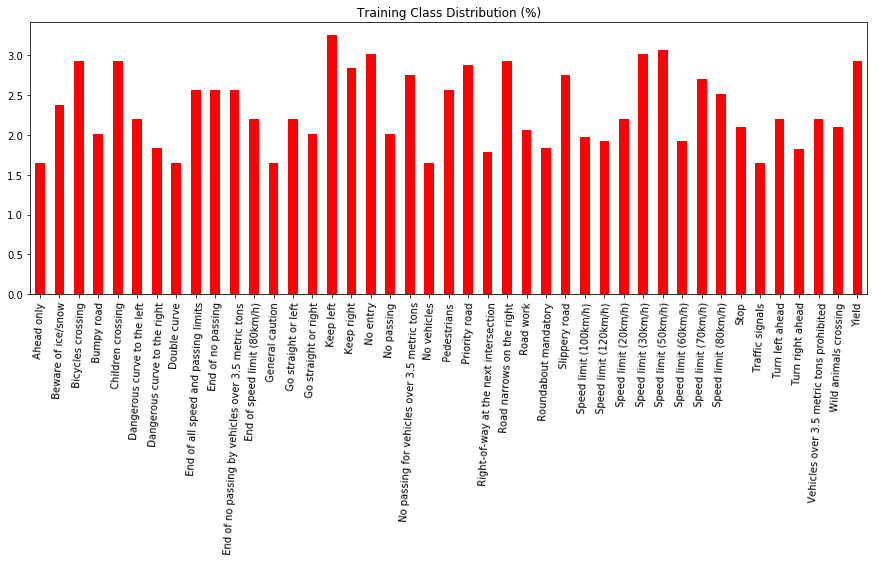

In [7]:
def balance_training_data(X_train_working_copy,y_train_working_copy,min_percentage=1): 
    '''
    Applies different image transformation techniques to generate more images for all those image classes that are
    below the min_percentage value till all classes are above the min_percentage value 
    '''
    balanced = False
    counter = 1;
    classes_to_exclude = []
    no_of_unbalanced_classes = len(get_below_percent_classes(y_train_working_copy,min_percentage,classes_to_exclude))
    print('Before balancing, number of unbalanced classes:{}\n***'.format(no_of_unbalanced_classes))
    while(not balanced and counter < 6):# 6 used as a fail-safe, otherwise the loop may continue forever & would result in a very large dataset
        before_count = y_train_working_copy.shape[0]
               
        ## 90 degree rotation
        # first find which classes can be rotated
        classes_to_include = set(get_below_percent_classes(y_train_working_copy,min_percentage,classes_to_exclude)).intersection(set(can_rotate_90_include))
        if (len(classes_to_include) > 0):
            print('Classes rotated 90 degrees: {}'.format(classes_to_include))
            rotated_images, rotated_images_classes, rotated_angles = rotate_images(X_train_working_copy,y_train_working_copy,classes_to_include,Include_Exlude_Flag.INCLUDE,90,91)
            X_train_working_copy = np.vstack((X_train_working_copy,rotated_images))
            y_train_working_copy = np.append(y_train_working_copy,rotated_images_classes)
        ##
        
        ## 180 degree rotation
        # first find which classes can be rotated
        classes_to_include = set(get_below_percent_classes(y_train_working_copy,min_percentage,classes_to_exclude)).intersection(set(can_rotate_180_include))
        if (len(classes_to_include) > 0):
            print('Classes rotated 180 degrees: {}'.format(classes_to_include))
            rotated_images, rotated_images_classes, rotated_angles = rotate_images(X_train_working_copy,y_train_working_copy,classes_to_include,Include_Exlude_Flag.INCLUDE,180,181)
            X_train_working_copy = np.vstack((X_train_working_copy,rotated_images))
            y_train_working_copy = np.append(y_train_working_copy,rotated_images_classes)
        ##
        
        ## Transpose left
        # first find which classes can be transposed right because those classes are the ones for which we generate more examples
        classes_to_include = set(get_below_percent_classes(y_train_working_copy,min_percentage,classes_to_exclude)).intersection(set(can_transpose_right_include))
        # Now get the actual transpose from classes, as those are the classes that we actually need to transpose from to generate examples
        # for left classes that have min percentage
        classes_transpose_from = []
        for cls in classes_to_include:
            classes_transpose_from.append(transpose_pair_dict[cls])
        if (len(classes_transpose_from) > 0):
            print('Classes transposed left: {}'.format(classes_transpose_from))
            transposed_images, transposed_images_classes = transpose_images(X_train_working_copy,y_train_working_copy,classes_transpose_from,transpose_pair_dict,Include_Exlude_Flag.INCLUDE,'right')
            X_train_working_copy = np.vstack((X_train_working_copy,transposed_images))
            y_train_working_copy = np.append(y_train_working_copy,transposed_images_classes)
        ##
        
        ## Transpose Right
        # first find which classes can be transposed left because those classes are the ones for which we generate more examples
        classes_to_include = set(get_below_percent_classes(y_train_working_copy,min_percentage,classes_to_exclude)).intersection(set(can_transpose_left_include))
        # Now get the actual transpose from classes, as those are the classes that we actually need to transpose from to generate examples
        # for right classes that have min percentage
        classes_transpose_from = []
        for cls in classes_to_include:
            classes_transpose_from.append(transpose_pair_dict[cls])
        if (len(classes_transpose_from) > 0):
            print('Classes transposed right: {}'.format(classes_transpose_from))
            transposed_images, transposed_images_classes = transpose_images(X_train_working_copy,y_train_working_copy,classes_transpose_from,transpose_pair_dict,Include_Exlude_Flag.INCLUDE,'left')
            X_train_working_copy = np.vstack((X_train_working_copy,transposed_images))
            y_train_working_copy = np.append(y_train_working_copy,transposed_images_classes)
        ##
        
        ## 15 degree random rotation
        # first exclude the classes that can't be rotated, such as keep left, keep right
        classes_to_include = set(get_below_percent_classes(y_train_working_copy,min_percentage,classes_to_exclude)).difference(set(can_rotate_15_exclude))
        if (len(classes_to_include) > 0):
            print('Classes rotated 15 degrees: {}'.format(classes_to_include))
            rotated_images, rotated_images_classes, rotated_angles = rotate_images(X_train_working_copy,y_train_working_copy,classes_to_include,Include_Exlude_Flag.INCLUDE,-15,16)
            X_train_working_copy = np.vstack((X_train_working_copy,rotated_images))
            y_train_working_copy = np.append(y_train_working_copy,rotated_images_classes)
        ##
        
        ## Zoom out 
        # first find which classes can be zoomed
        classes_to_include = get_below_percent_classes(y_train_working_copy,min_percentage,classes_to_exclude)
        if (len(classes_to_include) > 0):
            zoom_by_pixels = 2
            print('Classes zoomed out {} pixels: {}'.format(zoom_by_pixels, classes_to_include))
            zoomed_out_images, zoomed_out_images_classes = zoom_images(X_train_working_copy,y_train_working_copy,classes_to_include,Include_Exlude_Flag.INCLUDE,Zoomin_Zoomout_Flag.ZOOM_OUT,zoom_by_pixels)
            X_train_working_copy = np.vstack((X_train_working_copy,zoomed_out_images))
            y_train_working_copy = np.append(y_train_working_copy,zoomed_out_images_classes)
        ##
        
        ## Zoom in
        # first find which classes can be zoomed
        classes_to_include = get_below_percent_classes(y_train_working_copy,min_percentage,classes_to_exclude)
        if (len(classes_to_include) > 0):
            zoom_by_pixels = 2
            print('Classes zoomed in {} pixels: {}'.format(zoom_by_pixels, classes_to_include))
            zoomed_in_images, zoomed_in_images_classes = zoom_images(X_train_working_copy,y_train_working_copy,classes_to_include,Include_Exlude_Flag.INCLUDE,Zoomin_Zoomout_Flag.ZOOM_IN,zoom_by_pixels)
            X_train_working_copy = np.vstack((X_train_working_copy,zoomed_in_images))
            y_train_working_copy = np.append(y_train_working_copy,zoomed_in_images_classes)
        ##
        
        ## Shear
        # first find which classes can be sheared
        classes_to_include = get_below_percent_classes(y_train_working_copy,min_percentage,classes_to_exclude)
        if (len(classes_to_include) > 0):
            print('Classes sheared: {}'.format(classes_to_include))
            sheared_images, sheared_images_classes = shear_images(X_train_working_copy,y_train_working_copy,classes_to_include,Include_Exlude_Flag.INCLUDE)
            X_train_working_copy = np.vstack((X_train_working_copy,sheared_images))
            y_train_working_copy = np.append(y_train_working_copy,sheared_images_classes)
        ##
               
        after_count = y_train_working_copy.shape[0]
        print('Before current iteration processing, image count: {} --- After current iteration processing, image count: {}'.format(before_count,after_count))
        no_of_unbalanced_classes = len(get_below_percent_classes(y_train_working_copy,min_percentage,classes_to_exclude))
        print('After iteration {}, number of unbalanced classes:{}\n...'.format(counter,no_of_unbalanced_classes))
        balanced = False if  no_of_unbalanced_classes > 0 else True
        counter += 1
    return X_train_working_copy,y_train_working_copy

X_train_working_copy,y_train_working_copy = balance_training_data(X_train_working_copy,y_train_working_copy,1.6)
print_classes_percentage(y_train_working_copy)
# Draw training data set class distribution after image augmentation
df_bar_train = draw_distribution(y_train_working_copy, df_signnames, 'ClassId', 'SignName', 'Training Class Distribution', 'r')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
# Image pre-processing functions

def convert_to_grayscale(images):
    result = []
    for img in images:
        result.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return np.array(result)

# ********************NOT applied as it seems to make the images worse***************************#
def apply_gaussian_blur(images, kernel_size):
    result = []
    for img in images:
        result.append(cv2.GaussianBlur(img, (kernel_size, kernel_size), 0))
    return np.array(result)
    
def normalize_images(images,dataset_type):
    '''
    Normalizes images so that mean is 0 and standard-deviation is 1
    '''
    print('Mean before normalizing {} dataset: {:.3f}'.format(dataset_type,np.mean(images)))
    print('Standrd Deviation before normalizing {} dataset: {:.3f}'.format(dataset_type,np.std(images)))

    result = []
    for img in images:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            result.append(preprocessing.scale(img).astype(np.float32))
    print('Mean after normalizing {} dataset: {:.3f}'.format(dataset_type,np.mean(result)))
    print('Standrd Deviation after normalizing {} dataset: {:.3f}'.format(dataset_type,np.std(result)))
    return np.array(result)

def adjust_contrast(images):
    '''
    Makes images look sharper by applying Contrast Limited Adaptive Histogram Equalization (CLAHE) technique
    '''
    result = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for img in images:
        result.append(clahe.apply(img))
    return np.array(result)

def add_missing_color_channel(images):    
    return images.reshape(images.shape + (1,))

def reduce_noise_adapt_thresh(images):
    '''
    Adaptive Thresholding for reducing noise in the images
    '''
    result = []
    for img in images:
        result.append(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2))
    return np.array(result)

# ********************NOT applied as the affect is same reduce_noise_adapt_thresh***************************#
def reduce_noise_denoising(images):
    '''
    Denoising
    '''
    result = []
    for img in images:
        result.append(cv2.fastNlMeansDenoising(img,None))
    return np.array(result)

# TODO: Select shapes from the images as the mask and then extract foreground from image to discard background pixels i.e. noise
# https://www.pyimagesearch.com/2016/02/08/opencv-shape-detection/
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_grabcut/py_grabcut.html#grabcut

Mean before normalizing example dataset: 136.216
Standrd Deviation before normalizing example dataset: 127.202
Mean after normalizing example dataset: 0.000
Standrd Deviation after normalizing example dataset: 1.000


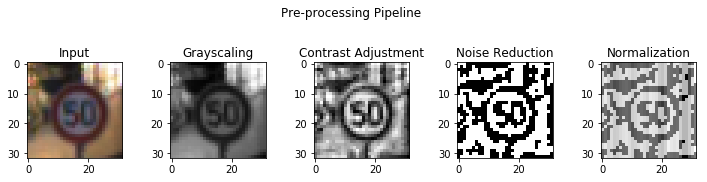

In [9]:
# Pre-processing visualization

example_image = X_train[32345].copy()
example_image = example_image.reshape(1,32,32,3)
fig = plt.figure(figsize=(12,3))
fig.subplots_adjust(hspace = .5, wspace = .5)
plt.suptitle('Pre-processing Pipeline')
plt.subplot(1, 5, 1)
plt.title('Input')
plt.imshow(example_image[0])

plt.subplot(1, 5, 2)
example_image = convert_to_grayscale(example_image)
plt.imshow(example_image[0].squeeze(),cmap='gray')
plt.title('Grayscaling')

plt.subplot(1, 5, 3)
example_image = adjust_contrast(example_image)
plt.imshow(example_image[0].squeeze(),cmap='gray')
plt.title('Contrast Adjustment')

plt.subplot(1, 5, 4)
example_image = reduce_noise_adapt_thresh(example_image)
plt.imshow(example_image[0].squeeze(),cmap='gray')
plt.title('Noise Reduction')

plt.subplot(1, 5, 5)
example_image = normalize_images(example_image,'example')
plt.imshow(example_image[0].squeeze(),cmap='gray')
plt.title('Normalization')

plt.show()

In [10]:
%%time
# Turn images to grayscale
print('Coverting {} images to grayscale...'.format('training'))
X_train_grayscale = convert_to_grayscale(X_train_working_copy)
print('Coverting {} images to grayscale...'.format('validation'))
X_valid_grayscale = convert_to_grayscale(X_valid_working_copy)

#plt.figure(figsize=(1,1))
#plt.imshow(X_train_working_copy[46164].squeeze(),cmap='gray')
#plt.title(str(y_train_working_copy[46164]))
#plt.show()

# Apply histogram normalization to balance the contrast i.e. make images look sharper
print("Adjusting {} images' contrast...".format('training'))
X_train_grayscale = adjust_contrast(X_train_grayscale)
print("Adjusting {} images' contrast...".format('validation'))
X_valid_grayscale = adjust_contrast(X_valid_grayscale)

# Apply adaptive threshold to reduce noise
print("Reducing {} images' noise...".format('training'))
X_train_grayscale = reduce_noise_adapt_thresh(X_train_grayscale)
print("Reducing {} images' noise...".format('validation'))
X_valid_grayscale = reduce_noise_adapt_thresh(X_valid_grayscale)

# Normalize images so that mean is 0 & standard deviation is 1
print("Normalizing {} images...".format('training'))
X_train_grayscale = normalize_images(X_train_grayscale,'training')
print("Normalizing {} images...".format('validation'))
X_valid_grayscale = normalize_images(X_valid_grayscale,'validation')

# Add the missing channel dim as grascaling removes the color channel dims
print("Adding missing color channel for {} images...".format('training'))
X_train_grayscale = add_missing_color_channel(X_train_grayscale)
print("Adding missing color channel for {} images...".format('validation'))
X_valid_grayscale = add_missing_color_channel(X_valid_grayscale)

Coverting training images to grayscale...
Coverting validation images to grayscale...
Adjusting training images' contrast...
Adjusting validation images' contrast...
Reducing training images' noise...
Reducing validation images' noise...
Normalizing training images...
Mean before normalizing training dataset: 129.671
Standrd Deviation before normalizing training dataset: 127.482
Mean after normalizing training dataset: -0.000
Standrd Deviation after normalizing training dataset: 0.986
Normalizing validation images...
Mean before normalizing validation dataset: 129.962
Standrd Deviation before normalizing validation dataset: 127.476
Mean after normalizing validation dataset: -0.000
Standrd Deviation after normalizing validation dataset: 0.998
Adding missing color channel for training images...
Adding missing color channel for validation images...
Wall time: 1min 5s


In [11]:
%%time
# Shuffle data
X_train_grayscale, y_train_working_copy = shuffle(X_train_grayscale, y_train_working_copy)

# Save pre-processed data
import os
import shutil
import pickle

processed_data_directory = './saved-processed-data/'
processed_data_file = processed_data_directory + 'traffic-signs-preprocessed-data.pickle'

if not os.path.exists(processed_data_directory):
    os.makedirs(processed_data_directory)  

print("Training images = ", X_train_grayscale.shape)
print("Training images' labels = ", y_train_working_copy.shape)
print("Validation images = ", X_valid_grayscale.shape)
print("Validation images' labels = ", y_valid_working_copy.shape)

if os.path.isfile(processed_data_file):
    os.remove(processed_data_file)
    
if not os.path.isfile(processed_data_file):
    print('Saving pre-processed data to pickle file...')
    try:
        with open(processed_data_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': X_train_grayscale,
                    'train_labels': y_train_working_copy,
                    'valid_dataset': X_valid_grayscale,
                    'valid_labels': y_valid_working_copy,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', processed_data_file, ':', e)
        raise

print('Pre-processed data saved in pickle file')

Training images =  (65518, 32, 32, 1)
Training images' labels =  (65518,)
Validation images =  (4410, 32, 32, 1)
Validation images' labels =  (4410,)
Saving pre-processed data to pickle file...
Pre-processed data saved in pickle file
Wall time: 4.79 s


In [12]:
%%time
# Reload the pre-processed data

import pickle
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn import preprocessing
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

processed_data_directory = './saved-processed-data/'
processed_data_file = processed_data_directory + 'traffic-signs-preprocessed-data.pickle'

with open(processed_data_file, 'rb') as f:
  pickle_data = pickle.load(f)
  X_train_grayscale = pickle_data['train_dataset']
  y_train_working_copy = pickle_data['train_labels']
  X_valid_grayscale = pickle_data['valid_dataset']
  y_valid_working_copy = pickle_data['valid_labels']
  del pickle_data  # Free up memory

print('Pre-processed data loaded')

print("Training images = ", X_train_grayscale.shape)
print("Training images' labels = ", y_train_working_copy.shape)
print("Validation images = ", X_valid_grayscale.shape)
print("Validation images' labels = ", y_valid_working_copy.shape)

Pre-processed data loaded
Training images =  (65518, 32, 32, 1)
Training images' labels =  (65518,)
Validation images =  (4410, 32, 32, 1)
Validation images' labels =  (4410,)
Wall time: 548 ms


### Model Architecture

In [13]:
# Hyper Parameters
MU = 0
SIGMA = 0.1
EPOCHS = 150
BATCH_SIZE = 128
LEARNING_RATE = 0.001
LOSS_BETA = 0.001
DECAY_AFTER_N_STEPS = 2500
DECAY_RATE = 0.90
PADDING = 'SAME'
STRIDES = 1
CONV_FILTER = 5
POOL_FILTER = 2

In [14]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1,padding='VALID'):
    '''
    Creates a Convolutional layer, adds bias and also adds ReLU activation
    '''
    x = tf.nn.conv2d(
        x, 
        W, 
        strides=[1, strides, strides, 1],  # [batch, height, width, depth]
        padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(activated_layer, k=2, padding='VALID'):
    '''
    Performs max pooling on an activated layer
    Stride size is same as the filter size
    '''
    return tf.nn.max_pool(
        activated_layer,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1], # [batch, height, width, depth]
        padding=padding)

def KhattakNet(x):    
    
    # Formula for finding Filter W & H, shown here for Width Only, same for Height 
    # based on  W_out = ((W_in−W_Filter+2Padding)/Stride) + 1
    # W_Filter = 2Padding + W_in - (Stride * (W_out - 1))
    '''
    BEWARE!!!
    
    TensorFlow uses the following equation for 'SAME' vs 'VALID' --->>>
    
    For a tensor of strides = [1, 1, 1, 1] # (batch, height, width, depth)

        SAME Padding, the output height and width are computed as: 
            out_height = ceil(float(in_height) / float(strides[1]))
            out_width = ceil(float(in_width) / float(strides[2]))

        VALID Padding, the output height and width are computed as:
            out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
            out_width = ceil(float(in_width - filter_width + 1) / float(strides[2]))
    '''
    # So based on above TF formula, SAME keeps output image size same if stride is 1
    
    # VALID vs SAME padding
    # SAME keeps output size same as input by adding 0s if STRIDE = 1, else half
    # VALID generally reduces the output size if the filter % dim != 0 (e.g. 28 % 3), use above formula with pdding = 0 to find output size
    # Basically with VALID, last column(s) & row(s) are dropped e.g. with 28x28 image & 3x3 filter with stride 1, output = 26x26

    # Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x16.
    input_depth1 = 1
    output_depth1 = 16
    #wc1 = tf.Variable(tf.truncated_normal([filter_height1, filter_width1, input_depth1, output_depth1], mean=MU, stddev=SIGMA))
    # With Xavier initializer (see https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/initializers.py)
    wc1 = tf.get_variable('wc1',shape=[CONV_FILTER, CONV_FILTER, input_depth1, output_depth1], initializer=tf.contrib.layers.xavier_initializer())
    # Add to collection for use in later regularization
    tf.add_to_collection('wc1',wc1)
    bc1 = tf.Variable(tf.zeros(output_depth1),name='bc1')
    c1 = conv2d(x,wc1,bc1,STRIDES,PADDING)
    # Pooling. Input = 32x32x16. Output = 16x16x16.
    c1_pld = maxpool2d(c1,POOL_FILTER,PADDING)
    # Pooling for direct feed at later stage. Input = 16x16x16. Output = 4x4x16.
    ##c1_pld2 = maxpool2d(c1_pld,4,'SAME')

    # Layer 2: Convolutional. Input = 16x16x16. Output = 16x16x32.
    input_depth2 = 16
    output_depth2 = 32
    #wc2 = tf.Variable(tf.truncated_normal([filter_height2, filter_width2, input_depth2, output_depth2], mean=MU, stddev=SIGMA))
    # With Xavier initializer
    wc2 = tf.get_variable('wc2',shape=[CONV_FILTER, CONV_FILTER, input_depth2, output_depth2], initializer=tf.contrib.layers.xavier_initializer())
    # Add to collection for use in later regularization
    tf.add_to_collection('wc2',wc2)
    bc2 = tf.Variable(tf.zeros(output_depth2),name='bc2')
    c2 = conv2d(c1_pld, wc2,bc2,STRIDES,PADDING)
    # Pooling. Input = 16x16x32. Output = 8x8x32.
    c2_pld = maxpool2d(c2,POOL_FILTER,PADDING)
    # Pooling for direct feed at later stage. Input = 8x8x32. Output = 4x4x32.
    ##c2_pld2 = maxpool2d(c2_pld,2,'SAME')
    
    # Layer 3: Convolutional. Input = 8x8x32. Output = 8x8x64.
    input_depth3 = 32
    output_depth3 = 64
    #wc3 = tf.Variable(tf.truncated_normal([filter_height3, filter_width3, input_depth3, output_depth3], mean=MU, stddev=SIGMA))
    # With Xavier initializer
    wc3 = tf.get_variable('wc3',shape=[CONV_FILTER, CONV_FILTER, input_depth3, output_depth3], initializer=tf.contrib.layers.xavier_initializer())
    # Add to collection for use in later regularization
    tf.add_to_collection('wc3',wc3)
    bc3 = tf.Variable(tf.zeros(output_depth3),name='bc3')
    c3 = conv2d(c2_pld,wc3,bc3,STRIDES,PADDING)
    # Pooling. Input = 8x8x64. Output = 4x4x64.
    c3_pld = maxpool2d(c3,POOL_FILTER,PADDING)
      
    # Concatenate all 3 layers Input = 4x4x16,4x4x32,4x4x64. Output = 4x4x112.
    # 3 = depth-wise
    ##conct = tf.concat([c1_pld2,c2_pld2,c3_pld],3)
    #print('Concatenated layers shape:{}'.format(conct.get_shape().as_list()))
    # Flatten. Input = 4x4x112. Output = 1792
    #conct_flt = flatten(conct)
    
    # Flatten. Input = 4x4x64. Output = 1024
    flt = flatten(c3_pld)
    
    # Layer 4: Fully Connected. Input = 1024. Output = 120.
    #w_fc1 = tf.Variable(tf.truncated_normal([1024,120], mean=MU, stddev=SIGMA))
    # With Xavier initializer
    w_fc1 = tf.get_variable('w_fc1',shape=[1024, 120], initializer=tf.contrib.layers.xavier_initializer())
    # Add to collection for use in later regularization
    tf.add_to_collection('w_fc1',w_fc1)
    b_fc1 = tf.Variable(tf.zeros(120),name='b_fc1')  
    fc1 = tf.add(tf.matmul(flt, w_fc1), b_fc1)
    # Activation.
    fc1 = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 5: Fully Connected. Input = 120. Output = 84.
    #w_fc2 = tf.Variable(tf.truncated_normal([120,84], mean=MU, stddev=SIGMA))
    # With Xavier initializer
    w_fc2 = tf.get_variable('w_fc2',shape=[120, 84], initializer=tf.contrib.layers.xavier_initializer())
    # Add to collection for use in later regularization
    tf.add_to_collection('w_fc2',w_fc2)
    b_fc2 = tf.Variable(tf.zeros(84),name='b_fc2')  
    fc2 = tf.add(tf.matmul(fc1, w_fc2), b_fc2)
    # Activation.
    fc2 = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 6: Fully Connected. Input = 84. Output = 43.
    #w_fc3 = tf.Variable(tf.truncated_normal([84,43], mean=MU, stddev=SIGMA))
    # With Xavier initializer
    w_fc3 = tf.get_variable('w_fc3',shape=[84, 43], initializer=tf.contrib.layers.xavier_initializer())
    # Add to collection for use in later regularization
    tf.add_to_collection('w_fc3',w_fc3)
    b_fc3 = tf.Variable(tf.zeros(43),name='b_fc3')  
    logits = tf.add(tf.matmul(fc2, w_fc3), b_fc3, name='logits')
    
    return logits

# Features and Labels
# x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.
x = tf.placeholder(tf.float32, (None, 32, 32, 1),name='X_input')
y = tf.placeholder(tf.int32, (None),name='y_input')
one_hot_y = tf.one_hot(y, 43) # a vector of 43 with only one value encoded as 1, rest 0s
keep_prob = tf.placeholder(tf.float32) # probability to not drop a perceptron


logits = KhattakNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# Loss without L2 Regularization
loss_no_l2 = tf.reduce_mean(cross_entropy)

# Add L2 Regularization to above loss
# first get weights for all layers
wc1 = tf.get_collection('wc1')
wc2 = tf.get_collection('wc2')
wc3 = tf.get_collection('wc3')
w_fc1 = tf.get_collection('w_fc1')
w_fc2 = tf.get_collection('w_fc2')
w_fc3 = tf.get_collection('w_fc3')

# Now add all weights
regularizer = tf.nn.l2_loss(wc1) + tf.nn.l2_loss(wc2) + tf.nn.l2_loss(wc3) + tf.nn.l2_loss(w_fc1)+ tf.nn.l2_loss(w_fc2) + tf.nn.l2_loss(w_fc3)
loss = loss_no_l2 + LOSS_BETA * regularizer

# Apply decaying learning rate i.e. the learning rate decreases with more epochs
global_step = tf.Variable(0, trainable=False) 
# 1 step = 1 training batch (for 5 epochs with 512 batches -> 2560 steps)
initial_learning_rate = LEARNING_RATE
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, DECAY_AFTER_N_STEPS, DECAY_RATE, staircase=True)

#optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE) # without decaying laearning rate
optimizer = tf.train.AdamOptimizer(learning_rate)
#training_operation = optimizer.minimize(loss) # without decaying learning rate
training_operation = optimizer.minimize(loss, global_step=global_step)


# Get the max index of class probabs from logits, compare against the max index from 1-hot encoded labels 
# If equal then it means the model made the correct prediction
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    '''
    Evaluates the average accuracy of the model for a given dataset.
    '''
    num_examples = len(X_data)
    total_accuracy = 0 # across all batches
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # get this batch's accuracy
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples # get the average accuracy across the complete dataset

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training...

Total examples for training = 65518

EPOCH 1 ...


Epoch  1/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:53<00:00,  2.49batches/s]


Validation Accuracy = 0.640

EPOCH 2 ...


Epoch  2/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:47<00:00,  2.50batches/s]


Validation Accuracy = 0.828

EPOCH 3 ...


Epoch  3/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.47batches/s]


Validation Accuracy = 0.884

EPOCH 4 ...


Epoch  4/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.52batches/s]


Validation Accuracy = 0.895

EPOCH 5 ...


Epoch  5/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.50batches/s]


Validation Accuracy = 0.910

EPOCH 6 ...


Epoch  6/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.925

EPOCH 7 ...


Epoch  7/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.931

EPOCH 8 ...


Epoch  8/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.44batches/s]


Validation Accuracy = 0.937

EPOCH 9 ...


Epoch  9/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.938

EPOCH 10 ...


Epoch 10/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.935

EPOCH 11 ...


Epoch 11/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.53batches/s]


Validation Accuracy = 0.946

EPOCH 12 ...


Epoch 12/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.937

EPOCH 13 ...


Epoch 13/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.947

EPOCH 14 ...


Epoch 14/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.945

EPOCH 15 ...


Epoch 15/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.49batches/s]


Validation Accuracy = 0.947

EPOCH 16 ...


Epoch 16/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:44<00:00,  2.40batches/s]


Validation Accuracy = 0.949

EPOCH 17 ...


Epoch 17/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:44<00:00,  2.51batches/s]


Validation Accuracy = 0.949

EPOCH 18 ...


Epoch 18/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.950

EPOCH 19 ...


Epoch 19/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.48batches/s]


Validation Accuracy = 0.944

EPOCH 20 ...


Epoch 20/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.952

EPOCH 21 ...


Epoch 21/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:44<00:00,  2.49batches/s]


Validation Accuracy = 0.952

EPOCH 22 ...


Epoch 22/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.940

EPOCH 23 ...


Epoch 23/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.949

EPOCH 24 ...


Epoch 24/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.950

EPOCH 25 ...


Epoch 25/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.958

EPOCH 26 ...


Epoch 26/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.53batches/s]


Validation Accuracy = 0.957

EPOCH 27 ...


Epoch 27/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.957

EPOCH 28 ...


Epoch 28/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.45batches/s]


Validation Accuracy = 0.958

EPOCH 29 ...


Epoch 29/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.951

EPOCH 30 ...


Epoch 30/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.952

EPOCH 31 ...


Epoch 31/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.956

EPOCH 32 ...


Epoch 32/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.48batches/s]


Validation Accuracy = 0.951

EPOCH 33 ...


Epoch 33/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.955

EPOCH 34 ...


Epoch 34/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.956

EPOCH 35 ...


Epoch 35/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.962

EPOCH 36 ...


Epoch 36/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.958

EPOCH 37 ...


Epoch 37/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.959

EPOCH 38 ...


Epoch 38/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.956

EPOCH 39 ...


Epoch 39/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.966

EPOCH 40 ...


Epoch 40/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.956

EPOCH 41 ...


Epoch 41/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.957

EPOCH 42 ...


Epoch 42/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.957

EPOCH 43 ...


Epoch 43/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.957

EPOCH 44 ...


Epoch 44/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:49<00:00,  2.35batches/s]


Validation Accuracy = 0.959

EPOCH 45 ...


Epoch 45/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:48<00:00,  2.53batches/s]


Validation Accuracy = 0.962

EPOCH 46 ...


Epoch 46/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.957

EPOCH 47 ...


Epoch 47/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.49batches/s]


Validation Accuracy = 0.961

EPOCH 48 ...


Epoch 48/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.964

EPOCH 49 ...


Epoch 49/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.44batches/s]


Validation Accuracy = 0.964

EPOCH 50 ...


Epoch 50/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.959

EPOCH 51 ...


Epoch 51/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.961

EPOCH 52 ...


Epoch 52/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.962

EPOCH 53 ...


Epoch 53/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.46batches/s]


Validation Accuracy = 0.960

EPOCH 54 ...


Epoch 54/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.966

EPOCH 55 ...


Epoch 55/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.961

EPOCH 56 ...


Epoch 56/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:47<00:00,  2.24batches/s]


Validation Accuracy = 0.962

EPOCH 57 ...


Epoch 57/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.962

EPOCH 58 ...


Epoch 58/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.961

EPOCH 59 ...


Epoch 59/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.961

EPOCH 60 ...


Epoch 60/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.48batches/s]


Validation Accuracy = 0.956

EPOCH 61 ...


Epoch 61/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.957

EPOCH 62 ...


Epoch 62/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.961

EPOCH 63 ...


Epoch 63/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.959

EPOCH 64 ...


Epoch 64/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.43batches/s]


Validation Accuracy = 0.961

EPOCH 65 ...


Epoch 65/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.45batches/s]


Validation Accuracy = 0.966

EPOCH 66 ...


Epoch 66/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.33batches/s]


Validation Accuracy = 0.962

EPOCH 67 ...


Epoch 67/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.964

EPOCH 68 ...


Epoch 68/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.964

EPOCH 69 ...


Epoch 69/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:44<00:00,  2.52batches/s]


Validation Accuracy = 0.963

EPOCH 70 ...


Epoch 70/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.52batches/s]


Validation Accuracy = 0.965

EPOCH 71 ...


Epoch 71/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.963

EPOCH 72 ...


Epoch 72/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.962

EPOCH 73 ...


Epoch 73/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.964

EPOCH 74 ...


Epoch 74/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.966

EPOCH 75 ...


Epoch 75/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.961

EPOCH 76 ...


Epoch 76/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.963

EPOCH 77 ...


Epoch 77/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.962

EPOCH 78 ...


Epoch 78/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.41batches/s]


Validation Accuracy = 0.962

EPOCH 79 ...


Epoch 79/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.52batches/s]


Validation Accuracy = 0.964

EPOCH 80 ...


Epoch 80/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.961

EPOCH 81 ...


Epoch 81/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.961

EPOCH 82 ...


Epoch 82/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.959

EPOCH 83 ...


Epoch 83/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.962

EPOCH 84 ...


Epoch 84/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.964

EPOCH 85 ...


Epoch 85/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.964

EPOCH 86 ...


Epoch 86/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.48batches/s]


Validation Accuracy = 0.961

EPOCH 87 ...


Epoch 87/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.50batches/s]


Validation Accuracy = 0.963

EPOCH 88 ...


Epoch 88/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.963

EPOCH 89 ...


Epoch 89/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.50batches/s]


Validation Accuracy = 0.963

EPOCH 90 ...


Epoch 90/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.47batches/s]


Validation Accuracy = 0.962

EPOCH 91 ...


Epoch 91/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.960

EPOCH 92 ...


Epoch 92/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.962

EPOCH 93 ...


Epoch 93/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.963

EPOCH 94 ...


Epoch 94/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.963

EPOCH 95 ...


Epoch 95/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:52<00:00,  2.42batches/s]


Validation Accuracy = 0.963

EPOCH 96 ...


Epoch 96/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:52<00:00,  2.50batches/s]


Validation Accuracy = 0.962

EPOCH 97 ...


Epoch 97/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.50batches/s]


Validation Accuracy = 0.961

EPOCH 98 ...


Epoch 98/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.961

EPOCH 99 ...


Epoch 99/150: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.53batches/s]


Validation Accuracy = 0.965

EPOCH 100 ...


Epoch 100/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.961

EPOCH 101 ...


Epoch 101/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.963

EPOCH 102 ...


Epoch 102/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.49batches/s]


Validation Accuracy = 0.963

EPOCH 103 ...


Epoch 103/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.38batches/s]


Validation Accuracy = 0.960

EPOCH 104 ...


Epoch 104/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.45batches/s]


Validation Accuracy = 0.962

EPOCH 105 ...


Epoch 105/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.965

EPOCH 106 ...


Epoch 106/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.963

EPOCH 107 ...


Epoch 107/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.963

EPOCH 108 ...


Epoch 108/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.963

EPOCH 109 ...


Epoch 109/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.50batches/s]


Validation Accuracy = 0.963

EPOCH 110 ...


Epoch 110/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.46batches/s]


Validation Accuracy = 0.966

EPOCH 111 ...


Epoch 111/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.963

EPOCH 112 ...


Epoch 112/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.962

EPOCH 113 ...


Epoch 113/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.50batches/s]


Validation Accuracy = 0.962

EPOCH 114 ...


Epoch 114/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.49batches/s]


Validation Accuracy = 0.962

EPOCH 115 ...


Epoch 115/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.961

EPOCH 116 ...


Epoch 116/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.50batches/s]


Validation Accuracy = 0.962

EPOCH 117 ...


Epoch 117/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.36batches/s]


Validation Accuracy = 0.962

EPOCH 118 ...


Epoch 118/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.53batches/s]


Validation Accuracy = 0.963

EPOCH 119 ...


Epoch 119/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.50batches/s]


Validation Accuracy = 0.960

EPOCH 120 ...


Epoch 120/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.961

EPOCH 121 ...


Epoch 121/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.962

EPOCH 122 ...


Epoch 122/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.961

EPOCH 123 ...


Epoch 123/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.962

EPOCH 124 ...


Epoch 124/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.52batches/s]


Validation Accuracy = 0.962

EPOCH 125 ...


Epoch 125/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.965

EPOCH 126 ...


Epoch 126/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:47<00:00,  2.49batches/s]


Validation Accuracy = 0.963

EPOCH 127 ...


Epoch 127/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:47<00:00,  2.51batches/s]


Validation Accuracy = 0.962

EPOCH 128 ...


Epoch 128/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.50batches/s]


Validation Accuracy = 0.965

EPOCH 129 ...


Epoch 129/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.47batches/s]


Validation Accuracy = 0.963

EPOCH 130 ...


Epoch 130/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.36batches/s]


Validation Accuracy = 0.962

EPOCH 131 ...


Epoch 131/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.51batches/s]


Validation Accuracy = 0.961

EPOCH 132 ...


Epoch 132/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.50batches/s]


Validation Accuracy = 0.961

EPOCH 133 ...


Epoch 133/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:47<00:00,  2.46batches/s]


Validation Accuracy = 0.959

EPOCH 134 ...


Epoch 134/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:51<00:00,  2.40batches/s]


Validation Accuracy = 0.962

EPOCH 135 ...


Epoch 135/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:55<00:00,  2.22batches/s]


Validation Accuracy = 0.962

EPOCH 136 ...


Epoch 136/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:44<00:00,  2.48batches/s]


Validation Accuracy = 0.962

EPOCH 137 ...


Epoch 137/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:57<00:00,  2.38batches/s]


Validation Accuracy = 0.961

EPOCH 138 ...


Epoch 138/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:49<00:00,  2.36batches/s]


Validation Accuracy = 0.962

EPOCH 139 ...


Epoch 139/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.50batches/s]


Validation Accuracy = 0.962

EPOCH 140 ...


Epoch 140/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:45<00:00,  2.52batches/s]


Validation Accuracy = 0.961

EPOCH 141 ...


Epoch 141/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:50<00:00,  2.40batches/s]


Validation Accuracy = 0.961

EPOCH 142 ...


Epoch 142/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:48<00:00,  2.52batches/s]


Validation Accuracy = 0.963

EPOCH 143 ...


Epoch 143/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:47<00:00,  2.50batches/s]


Validation Accuracy = 0.963

EPOCH 144 ...


Epoch 144/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:47<00:00,  2.50batches/s]


Validation Accuracy = 0.965

EPOCH 145 ...


Epoch 145/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:48<00:00,  2.51batches/s]


Validation Accuracy = 0.961

EPOCH 146 ...


Epoch 146/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:48<00:00,  2.53batches/s]


Validation Accuracy = 0.966

EPOCH 147 ...


Epoch 147/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.49batches/s]


Validation Accuracy = 0.964

EPOCH 148 ...


Epoch 148/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.35batches/s]


Validation Accuracy = 0.964

EPOCH 149 ...


Epoch 149/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:46<00:00,  2.51batches/s]


Validation Accuracy = 0.962

EPOCH 150 ...


Epoch 150/150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [03:48<00:00,  2.54batches/s]


Validation Accuracy = 0.962

Model saved


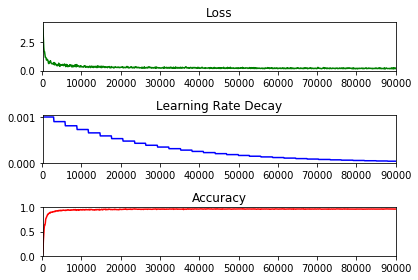

Wall time: 9h 37min 28s


In [15]:
%%time

### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

# Training Pipeline
# Create a training pipeline that uses the model to classify Traffic Sign data.

# Train Model
# Run the training data through the training pipeline to train the model.
# Before each epoch, shuffle the training set.
# After each epoch, measure the loss and accuracy of the validation set.
# Save the model after training.
import os
import shutil
import io

# Measurements used for graphing loss and accuracy
log_batch_step = 100
batches = []
loss_batch = []
#train_accuracy_batch = []
valid_accuracy_batch = []
learning_rate_decay = []
average_validation_accuracy = 0
model_directory = './saved-models/khattaknet-' + str(EPOCHS) + '-' + str(BATCH_SIZE) + '/'
saver = tf.train.Saver()
#log_writer = tf.train.SummaryWriter(model_directory, graph=tf.get_default_graph())
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_grayscale)
    
    print("Training...")
    print()
    
    print("Total examples for training = {}".format(num_examples))
    print()
    
    batch_count = int(math.ceil(num_examples/BATCH_SIZE))
    
    for i in range(EPOCHS):
        print("EPOCH {} ...".format(i+1))
        X_train_grayscale, y_train_working_copy = shuffle(X_train_grayscale, y_train_working_copy)
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(i+1, EPOCHS), unit='batches')
       
        for batch_i in batches_pbar:
            batch_start = batch_i*BATCH_SIZE
            batch_x, batch_y = X_train_grayscale[batch_start:batch_start + BATCH_SIZE], y_train_working_copy[batch_start:batch_start + BATCH_SIZE]         
            _,t_loss,l_rate,steps = sess.run([training_operation,loss,learning_rate,global_step], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})                      
            # Log every 100 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy after n batches
                #training_accuracy = sess.run(accuracy_operation, feed_dict={x: X_train_grayscale, y: y_train_working_copy, keep_prob: 1.0})
                validation_accuracy = sess.run(accuracy_operation, feed_dict={x: X_valid_grayscale, y: y_valid_working_copy, keep_prob: 1.0})

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(t_loss)
                learning_rate_decay.append(l_rate)
                #train_accuracy_batch.append(training_accuracy)
                valid_accuracy_batch.append(validation_accuracy)

        # Calculate Validation accuracy for this epoch i.e. across all batches for the complete dataset
        validation_accuracy_epoch = evaluate(X_valid_grayscale, y_valid_working_copy) # for this EPOCH
        average_validation_accuracy = validation_accuracy_epoch * 100 # just for keeping hold of last accuracy for writing out to file
        
        print("Validation Accuracy = {:.3f}".format(validation_accuracy_epoch))
        print()
        
   
    if os.path.exists(model_directory):
        shutil.rmtree(model_directory, ignore_errors=True)
    else:
        os.makedirs(model_directory)
    saver.save(sess, model_directory + 'khattaknet')
    print("Model saved")
    
model_params_file = open(model_directory + 'model-params.txt', 'w')                     
model_params_file.write('EPOCHS >>> {}\n'.format(EPOCHS))
model_params_file.write('BATCH SIZE >>> {}\n'.format(BATCH_SIZE))
model_params_file.write('LEARNING RATE >>> {}\n'.format(LEARNING_RATE))
model_params_file.write('BATCH SIZE >>> {}\n'.format(BATCH_SIZE))

model_params_file.write('PADDING >>> {}\n'.format(PADDING))
model_params_file.write('STRIDES >>> {}\n'.format(STRIDES))
model_params_file.write('CONVOLUTION FILTER >>> {}x{}\n'.format(CONV_FILTER,CONV_FILTER))
model_params_file.write('POOLING FILTER >>> {}x{}\n'.format(POOL_FILTER,POOL_FILTER))
model_params_file.write('LOSS BETA >>> {}\n'.format(LOSS_BETA))
model_params_file.write('DECAY AFTER N STEPS >>> {}\n'.format(DECAY_AFTER_N_STEPS))
model_params_file.write('DECAY RATE >>> {}\n'.format(DECAY_RATE))
model_params_file.write('MU >>> {}\n'.format(MU))
model_params_file.write('SIGMA >>> {}\n'.format(SIGMA))
model_params_file.write('VALIDATION ACCURACY >>> {:.3f}\n'.format(average_validation_accuracy))
model_params_file.close()
    
loss_plot = plt.subplot(311)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])

l_rate_plot = plt.subplot(312)
l_rate_plot.set_title('Learning Rate Decay')
l_rate_plot.plot(batches, learning_rate_decay, 'b')
l_rate_plot.set_xlim([batches[0], batches[-1]])

accuracy_plot = plt.subplot(313)
accuracy_plot.set_title('Accuracy')
#accuracy_plot.plot(batches, train_accuracy_batch, 'x', label='Training Accuracy')
accuracy_plot.plot(batches, valid_accuracy_batch, 'r', label='Validation Accuracy')
accuracy_plot.set_ylim([0, 1.0])
accuracy_plot.set_xlim([batches[0], batches[-1]])
#accuracy_plot.legend(loc=4)

plt.tight_layout()
plt.show()

In [16]:
# Test Model
# ******************** ONLY RUN ONCE!!!!!!!!!!!!!!!!!!!!!!!!!! if happy with model's validation accuracy*************************
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import warnings
from sklearn import preprocessing
%matplotlib inline

testing_file = 'traffic-signs-data/test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_test, y_test = test['features'], test['labels']
X_test_working_copy = X_test.copy()
y_test_working_copy = y_test.copy()
n_test = X_test_working_copy.shape[0]
print("Number of test images =", n_test)

print('Coverting {} images to grayscale...'.format('test'))
X_test_grayscale = convert_to_grayscale(X_test_working_copy)
print("Adjusting {} images' contrast...".format('test'))
X_test_grayscale = adjust_contrast(X_test_grayscale)
print("Reducing {} images' noise...".format('test'))
X_test_grayscale = reduce_noise_adapt_thresh(X_test_grayscale)
print("Normalizing {} images...".format('test'))
X_test_grayscale = normalize_images(X_test_grayscale,'test')
print("Adding missing color channel for {} images...".format('test'))
X_test_grayscale = add_missing_color_channel(X_test_grayscale)


test_model_directory = './saved-models/khattaknet-' + str(EPOCHS) + '-' + str(BATCH_SIZE) + '/'

with tf.Session() as sess:
    test_saver = tf.train.import_meta_graph(test_model_directory + 'khattaknet.meta')
    test_saver.restore(sess, tf.train.latest_checkpoint(test_model_directory)) 
    test_accuracy = evaluate(X_test_grayscale, y_test_working_copy)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Number of test images = 12630
Coverting test images to grayscale...
Adjusting test images' contrast...
Reducing test images' noise...
Normalizing test images...
Mean before normalizing test dataset: 129.551
Standrd Deviation before normalizing test dataset: 127.483
Mean after normalizing test dataset: -0.000
Standrd Deviation after normalizing test dataset: 0.997
Adding missing color channel for test images...
INFO:tensorflow:Restoring parameters from ./saved-models/khattaknet-150-128/khattaknet
Test Accuracy = 0.939


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

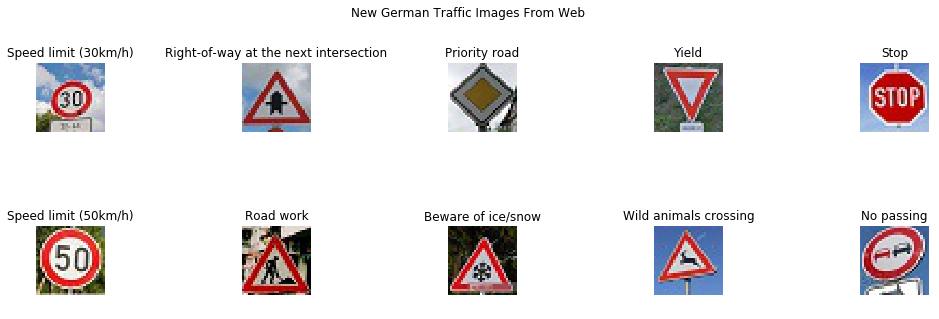

In [17]:
### Load the images and plot them here.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import warnings
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
%matplotlib inline

image_count = 0
correct_dim_image_count = 0
new_images = []
new_images_classes = []
new_images_classes_string = []

image_list = os.listdir("test-images/")
for image_name in image_list:
    image_count +=1
    full_image_path = 'test-images/' + image_name
    image = mpimg.imread(full_image_path)
    if (image.shape[0] != 32 and image.shape[1] != 32):
        print('{} image dimensions are {}x{}. These should be 32x32, Please resize image first!!!'.format(image_name,image.shape[0],image.shape[1]))        
    else:
        correct_dim_image_count +=1
        new_images.append(image)
        image_class = image_name.split('.')[0]
        new_images_classes.append(image_class)

if (image_count != correct_dim_image_count): raise Exception("Resize all images to 32x32 first!!!") 

new_images = np.array(new_images, dtype=np.uint8)
new_images_classes = np.array(new_images_classes, dtype=np.uint8)
    
df_signnames = pd.read_csv('signnames.csv')
fig = plt.figure(figsize=(16, 5))
fig.subplots_adjust(hspace = .5, wspace = 2)
plt.suptitle('New German Traffic Images From Web')
for i in range(image_count):
    plt.subplot(2, 5, i+1)
    # get the row from the signnames csv that has the same ClassId as the image's file name
    df_image_class= df_signnames[df_signnames['ClassId'] == new_images_classes[i]]
    # get the SignName column value
    image_class_string = df_image_class.iloc[0]['SignName']
    new_images_classes_string.append(image_class_string)
    plt.imshow(new_images[i])
    plt.title(image_class_string)
    plt.axis('off')
plt.show()

### Predict the Sign Type for Each Image

Number of images to predict = 10
Coverting new images images to grayscale...
Adjusting new images images' contrast...
Reducing new images images' noise...
Normalizing new images images...
Mean before normalizing new images dataset: 128.073
Standrd Deviation before normalizing new images dataset: 127.499
Mean after normalizing new images dataset: -0.000
Standrd Deviation after normalizing new images dataset: 1.000
Adding missing color channel for new images images...
INFO:tensorflow:Restoring parameters from ./saved-models/khattaknet-150-128/khattaknet


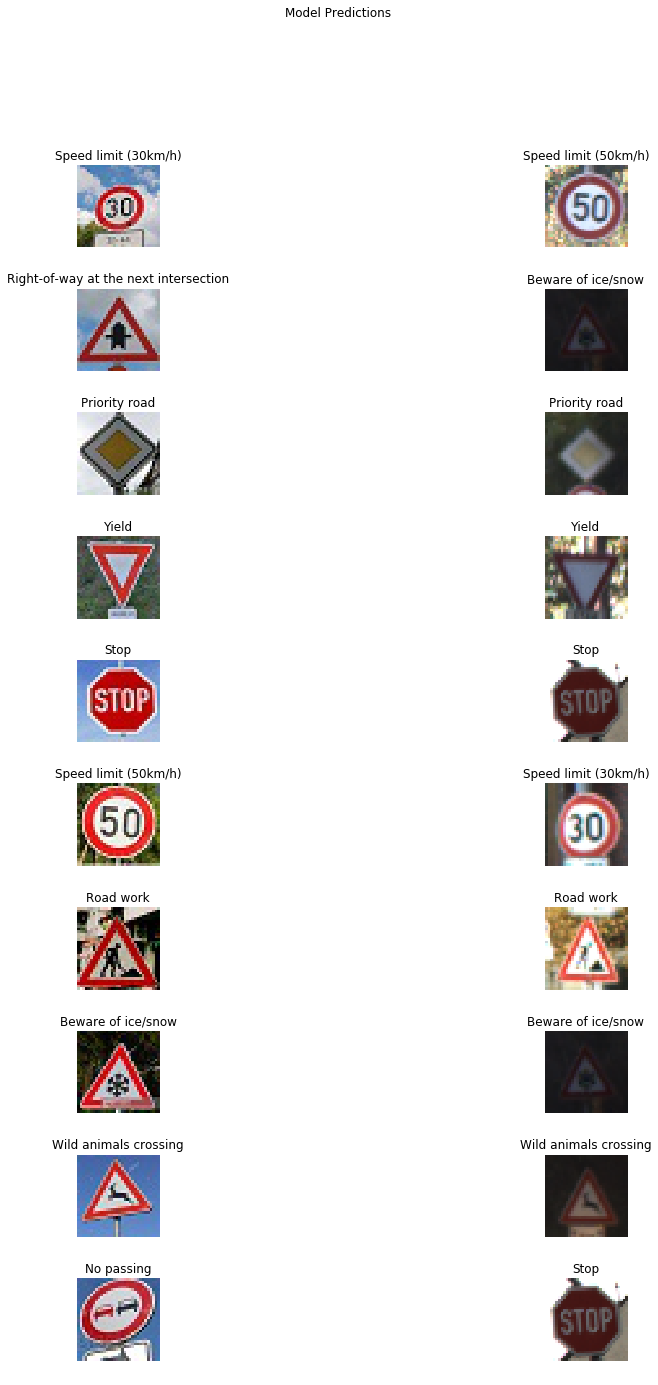

In [18]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.

X_predict_working_copy = new_images.copy()
y_predict_working_copy = new_images_classes.copy()
print("Number of images to predict =", X_predict_working_copy.shape[0])

# Image pre-processing
print('Coverting {} images to grayscale...'.format('new images'))
X_predict_grayscale = convert_to_grayscale(X_predict_working_copy)
print("Adjusting {} images' contrast...".format('new images'))
X_predict_grayscale = adjust_contrast(X_predict_grayscale)
print("Reducing {} images' noise...".format('new images'))
X_predict_grayscale = reduce_noise_adapt_thresh(X_predict_grayscale)
print("Normalizing {} images...".format('new images'))
X_predict_grayscale = normalize_images(X_predict_grayscale,'new images')
print("Adding missing color channel for {} images...".format('new images'))
X_predict_grayscale = add_missing_color_channel(X_predict_grayscale)

predict_model_directory = './saved-models/khattaknet-' + str(EPOCHS) + '-' + str(BATCH_SIZE) + '/'
#predict_model_directory = './saved-models/khattaknet-50-128/'
#predict_model_directory = './saved-models/khattaknet-150-128/'

prediction_probs = tf.nn.softmax(logits)
correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
top5_predictions = tf.nn.top_k(prediction_probs, k=5)
top5 = None
predicts = None

with tf.Session() as sess:
    predict_saver = tf.train.import_meta_graph(predict_model_directory + 'khattaknet.meta')
    predict_saver.restore(sess, tf.train.latest_checkpoint(predict_model_directory))
    
    top5,predicts = sess.run([top5_predictions,correct_predictions], feed_dict = {x:X_predict_grayscale,y:y_predict_working_copy,keep_prob:1.0})
    predicts = np.array(predicts) 
    
fig = plt.figure(figsize=(16, 22))
fig.subplots_adjust(hspace = .5, wspace = .1)
plt.suptitle('Model Predictions')
for i in range(image_count):
    plt.subplot(10, 2, (i*2)+1)
    plt.imshow(new_images[i])
    plt.title(new_images_classes_string[i])
    plt.axis('off')

    plt.subplot(10, 2, (i*2)+2)
    # get first image from validation dataset that has the same class as the predicted class
    predicted_image_index = np.where(y_test == top5.indices[i,0])[0][0]
    plt.imshow(X_test[predicted_image_index])
    df_predict_image = df_signnames[df_signnames['ClassId'] == y_test[predicted_image_index]]
    label = df_predict_image.iloc[0]['SignName']
    plt.title(label)
    plt.axis('off')
plt.show()

### Analyze Performance

In [19]:
### Calculate the accuracy for 10 new images. 
### For example, if the model predicted 2 out of 10 signs correctly, it's 20% accurate on these new images.
print("Predict Accuracy = {:.2f}%".format((len(predicts[predicts == True])/len(predicts))*100))

Predict Accuracy = 60.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

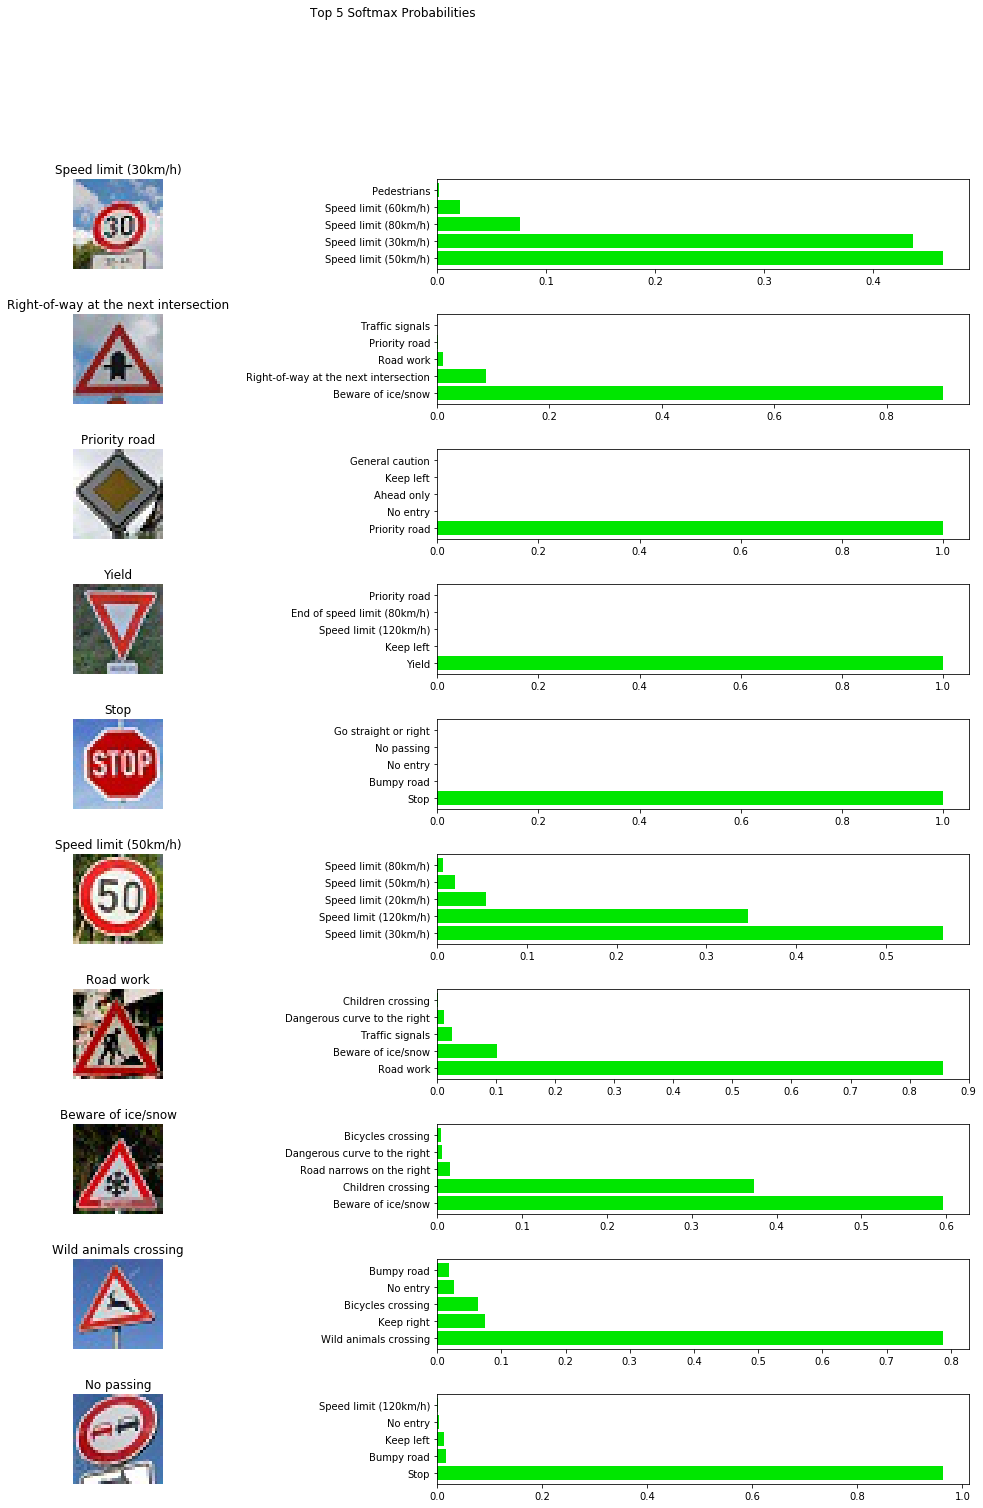

In [20]:
fig = plt.figure(figsize=(20, 24))
fig.subplots_adjust(hspace = .5, wspace = .1)
plt.suptitle('Top 5 Softmax Probabilities')
for i in range(image_count):
    plt.subplot(10, 2, (i*2)+1)
    plt.imshow(new_images[i])
    plt.title(new_images_classes_string[i])
    plt.axis('off')

    plt.subplot(10, 2, (i*2)+2)
    plt.barh(np.arange(1, 6, 1), top5.values[i, :],color='#00e600')
    labels = [df_signnames.iloc[j]['SignName'] for j in top5.indices[i,:]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()